In [1]:
import pyiron
import numpy as np
from gaussian_process_regression import GaussianProcessRegressionJob

c:\Users\f.fuchs\AppData\Local\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Prepare test set
X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
Y = np.squeeze(X * np.sin(X))

rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(Y.size), size=20, replace=False)

X_train, Y_train = X[training_indices], Y[training_indices]
noise_std = 0.75
Y_train_noisy = Y_train + rng.normal(loc=0.0, scale=noise_std, size=Y_train.shape)

In [3]:
pr = pyiron.Project("gaussian_process_regression")
job = pr.create_job(GaussianProcessRegressionJob, job_name="implementation", delete_existing_job=False)

# The data preparation
job.input.xSamples = X_train
job.input.ySamples = Y_train_noisy

# The parameters for the fitting procedure
# The kernel
job.input.kernel = "Gaussian"
job.input.initialLengthScaleBounds = [1e-2, 1e2]
job.input.initialLengthScale = 1.0
job.input.nu = 1.5
# Other parameters
job.input.optimizer = "optuna"
job.input.optimizer = "fmin_l_bfgs_b"
job.input.nTrials = 20
job.input.nRestartsOptimizer = 9
job.input.normalize_y_data = False
job.input.noise = noise_std**2

job.run()

2025-06-30 09:59:25,382 - pyiron_log - WARNING - The job implementation is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


In [4]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,2,finished,None,implementation,/implementation,None,//nextsim.etit.tu-chemnitz.de/projects/DiMoGraph/bearbeitung/13_workflow_surrogated_model_for_workflow_store/gaussian_process_regression/,2025-06-30 09:58:47.655462,None,None,pyiron@ensnb367#1,GaussianProcessRegressionJob,0.4,None,None


(0.0, 10.0)

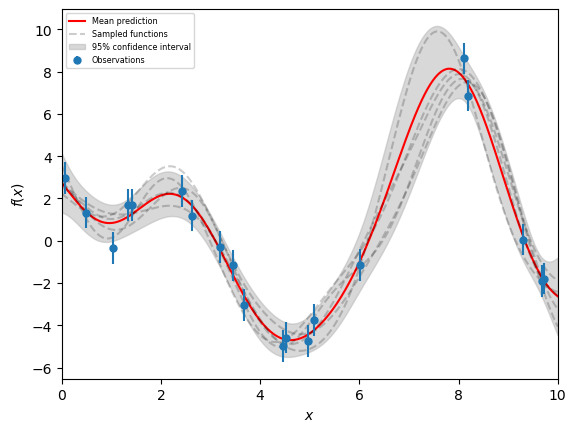

In [5]:
import matplotlib.pyplot as plt

# Plot the mean prediction
mean_prediction, std_prediction = job.gaussian_process.predict(X, return_std=True)
plt.plot(X, mean_prediction, color='r', label="Mean prediction")

# Plot samples functions
y_samples = job.gaussian_process.sample_y(X, 5)
for idx, sample in enumerate(y_samples.T):
    if idx == 0:
        label = f"Sampled functions"
    else:
        label = None
    plt.plot(
        X, sample,
        linestyle="--", color='k', alpha=0.2, label=label,
    )


# Plot the training data
plt.errorbar(
    X_train,
    Y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)

# Plot confidence intervall
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="0.7",
    alpha=0.5,
    label=r"95% confidence interval",
)

plt.legend(fontsize='xx-small')
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.xlim(min(X), max(X))